# Imports

In [79]:
!pip install numpy pandas matplotlib plotly scipy scikit-image scikit-learn torch torchvision kagglehub
!pip install nbformat

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import kagglehub
import os

In [81]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    pmem = True
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    pmem = False
else:
    device = torch.device("cpu")
    pmem = False
print(device)

mps


In [82]:
transform = transforms.Compose([transforms.ToTensor()])
images = torchvision.datasets.ImageFolder("coil-20-proc", transform=transform)
print(images.classes)
train_images = DataLoader(images, batch_size=72, shuffle=True, pin_memory=pmem)

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']


In [83]:
train_images

In [84]:
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=3,out_channels=32,
        kernel_size=5,padding=2
    )
)
model.add_module('relu1',nn.ReLU())
model.add_module('pool1',nn.MaxPool2d(kernel_size=2))

model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5,padding=2
    )
)
model.add_module('relu2',nn.ReLU())
model.add_module('pool2',nn.MaxPool2d(kernel_size=2))

model.add_module('flatten',nn.Flatten())

x = torch.ones((4,3,128,128))
dims = model(x).shape

model.add_module('fc1',nn.Linear(dims[1], 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout',nn.Dropout(p=0.5))
model.add_module('fc2',nn.Linear(1024,20))
model.to(device)

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=20, bias=True)
)

In [85]:
num_epochs = 5

loss_history_train = np.zeros(num_epochs)
accuracy_history_train = np.zeros(num_epochs)
loss_history_valid = np.zeros(num_epochs)
accuracy_history_valid = np.zeros(num_epochs)

In [86]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [87]:
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_images:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        loss_history_train[epoch] += loss.item()*y_batch.size(0)
        accuracy_history_valid[epoch] += is_correct.sum()
    
    model.eval()
    print(epoch)


0
1
2
3
4


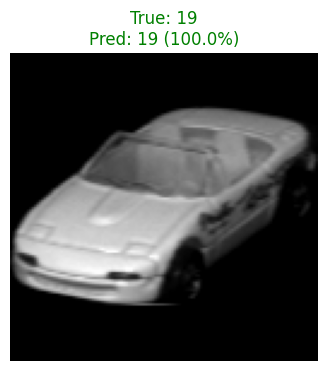

In [88]:
img_tensor, label = images[775]
input_tensor = img_tensor.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    logits = model(input_tensor)
    probs = F.softmax(logits, dim=1)
    confidence, pred_label = torch.max(probs,1)

    predicted_class = images.classes[pred_label.item()]
    true_class = images.classes[label]
    conf_score = confidence.item()

    plt.figure(figsize=(4,4))
    plt.imshow(img_tensor.permute(1,2,0))
    title_color = 'green' if predicted_class == true_class else 'red'
    plt.title(f"True: {true_class}\nPred: {predicted_class} ({conf_score:.1%})", color=title_color)
    plt.axis('off')
    plt.show()

In [89]:
count_correct = 0
incorrect = []
for i in range(1440):
    img_tensor, label = images[i]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        probs = F.softmax(logits, dim=1)
        confidence, pred_label = torch.max(probs,1)

        predicted_class = images.classes[pred_label.item()]
        true_class = images.classes[label]
        conf_score = confidence.item()
        if predicted_class == true_class:
            count_correct += 1
        else:
            incorrect.append(i)


In [91]:
count_correct

1440

In [ ]:
count_correct/1440